# Practice III Machine Learning
## `Masters Degree in Data Science`
# <font color='orange'>CUNEF</font>
## By Gabriela Gutiérrez-Colomer Santos: g.gutierrezcolomer@cunef.edu

## In this notebook we will deal with everything related to interpretability, for a better understanding we will divide the notebook in 3 parts: 
<ol style="font-size:18px; font-family: Arial">
  <li>Mathematical interpretability of the model:</li>
    <span style="color: red">How is LinearSVC able to predict? </span>
  <li>Interpretability of the predictions:</li>
    <span style="color: red"> Why does the model decide that this opinion is bad or good? How should a review be done to generate impact?</span>
  <li>Graphs and other possible clustering options to better understand the opinions.</li>
</ol>


#### Notebook III, Interpretability

In [1]:
%%capture
%run -i temp.py
import shap
from sklearn.ensemble import RandomForestClassifier

In [2]:
%%capture
%run 1_EDA_MODEL.ipynb #import the notebook

# 1. Mathematical Interpretability of the LinearSVC model
### How is LinearSVC able to predict? 
In a **linear support vector machine (SVM)**, the goal is to find the **hyperplane** in the feature space that **maximally separates the positive and negative classes**. This hyperplane is defined by a set of weights $w$ and a bias term $b$, and can be represented mathematically as follows:
\begin{equation}
w^{T} \cdot x + b = 0
\end{equation}

where $w$ is the weight vector, $x$ is the feature vector of a data point, and $b$ is the bias term.

The **hyperplane is defined** such that all points $x$ that satisfy the equation above are on one side of the hyperplane, and all points **that do not satisfy the equation are on the other side**. The weights $w$ and bias $b$ are chosen such that the distance between the hyperplane and the closest data points on either side is maximized. These data points are called support vectors, and the distance between the hyperplane and the support vectors is called the margin.

![svm](../images/svm.png)

For example in the picture, we can see that the red and blue dots are separated, imagine the blue dots being class 1 and the red dots being class 0. 
Once the hyperplane has been found, it can be used to classify new data points by evaluating the equation above for each data point and assigning it to the positive or negative class depending on which side of the hyperplane it falls on.

In [3]:
df = restaurant_reviews_pen
df['top_experience'] = df['review_stars'].apply(lambda x: 1 if x >= 4 else 0)

In [4]:
df = df.iloc[::150]

In [5]:
X = df['text']
y = df['top_experience']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7, stratify=y)

In [7]:
vectorizer = TfidfVectorizer(min_df=10)
X_train_vec = vectorizer.fit_transform(X_train).toarray()
X_test_vec = vectorizer.transform(X_test).toarray()

model = RandomForestClassifier()
model.fit(X_train_vec, y_train)

RandomForestClassifier()

In [8]:
feature_names = vectorizer.get_feature_names()
explainer = shap.Explainer(model, X_train_vec, feature_names=feature_names)
shap_values = explainer(X_test_vec)
print(shap_values.values.shape)

(252, 682, 2)


# 2. Interpretability of Predictions
### How does the model decide if this is a good or bad review? How should a review be done in order to make an impact?

**SHAP (SHapley Additive exPlanations)** values are a method for explaining the output of any machine learning model. They provide a way to understand how each feature contributes to the model's predictions, by estimating the value of each feature's contribution to the prediction. SHAP values are particularly useful for explaining the predictions of complex models, such as deep neural networks, because they can break down the prediction to show the contribution of each feature, rather than just providing a global model-level explanation.

One reason that SHAP values are useful is that they can help with model interpretability and understanding. By understanding the features that are most important to a model's predictions, you can get insight into how the model is making its decisions, and you can use this information to improve the model or to build trust in its predictions.

SHAP values are also useful for model debugging, because they can help you identify which features are causing the model to make mistakes. By understanding which features are having the greatest impact on the model's predictions, you can focus your efforts on improving the model's performance on those features.

Overall, SHAP values are a useful tool for understanding, interpreting, and debugging machine learning models.

Lets take a look at this graph. This is a SHAP value graph called waterfall. This graph represents how each feature contributes to each prediction in a local way, as you can see we are observing row number 67 `ind = 67`. 

Row number 67 has several columns bu one of them is the column `text` that we used for prediction in the before notebook; the review of that row is printed below. As we can see in the graph there are several words with a number next to them, the ones that have a number are the ones that actually appear in the review of that specific column, those that have a 0 next to them do not appear. 

There is a number at the bottom of the graph that says something like: $f(x) = 0.693$ that is the base value, SHAP values modify this base value, depending on the words the base value will be increased or decreased, for example: 

- We see the word **not** as our first word. The number next to the word not $0.089$ is indicating the TF-IDF score (how important the word is), the blue arrow next to it with a $-0.05$ inside is indicating **how** that word is actually decreasing the base value. Okay but, what does this mean? Well the word **not** is actually not so important as a bad review indicator because it has a low TF-IDF but it has a high value when decreasing the base value (decreasing the posibility of being classified as top_experience). 
- The word **soggy**: this one has a high TF-IDF $0.431$ and  a quite high SHAP value of $-0.04$; this means this word is actually very important for the model to classify this review as bad, it decreases the base value a $0.04$. 
- The word **some**: this one has a high TF-IDF $0.124$ and a low SHAP value (in absolute value) $+0.02$, this means that although being important, this word increasses slighly the probability of this restaurant of bein classfied as good. 

### After analysing some of the words can we say about the interpretability?

The way the model predicts and decides what restaurants belong to one class or another are due to the context of the sentence, words give a kind of "points" to the base value, bad words, yeah those that you will consider bad, decrease the points (base value) and those that are good, sum up points (increase the base value). 
Natural Language Processing sums and substracts points from using bad or good words but.... WHAT ARE THE BAD WORDS AND WHAT ARE THE GOOD WORDS? Well....

As we saw in the first notebook, the EDA notebook, good words are considered to be: amazing, lovely, happy, good, delicious, great etc. And why are those considered good? Because the algorithm knows for sure that those words cannot be in a bad context, lovely or good cannot be related to bad experiences because the human language says so. 

The same idea would be apply to bad words, such as terrible, horrible, disgusting, worst etc. There is no way this words are connected to a positive environment, they mean something bad in the human language.  

I went thru the drive thru today. i ordered the tendercrisp sandwich. After leaving I opened my sandwich and took a bite. It wa soggy bun with a dark meat soggy chicken on the roll with some kind of sauce on it. I rarely eat at KFC because every time I do I am not satisfied. I think I will just stop going


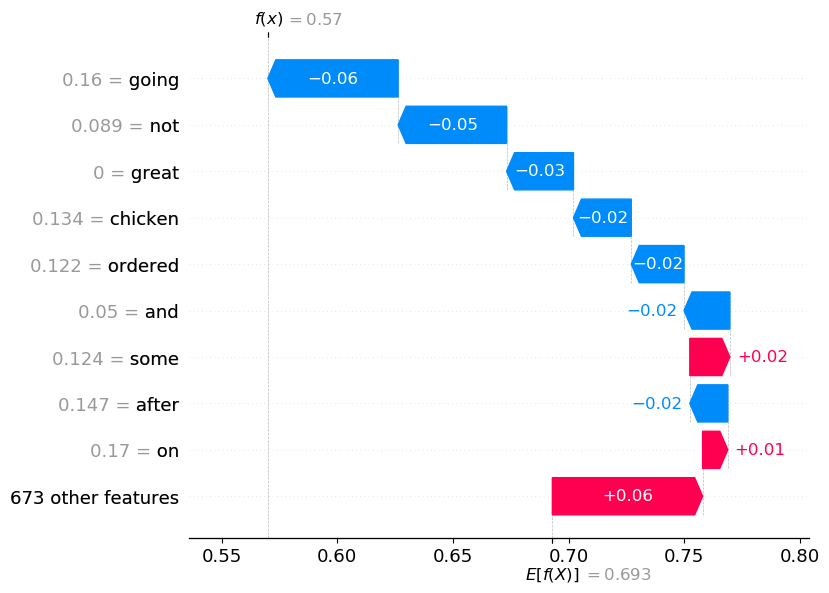

In [9]:
shap.initjs()
ind = 67

print(X_test.iloc[ind])

shap.plots.waterfall(shap_values[ind,:,1])

Lets now analyze this graph. The graph below appears to have a higher prediction value $f(x) = 0.87$. This means we are facing a good review. Lets see first the words that increase the base value an thus are considered to be good in the human language: 
- **delicious**: delicious means tasty, with flavour, good and pleasant, if we disliked something we would never use this word for describing it, that is why the algorithm knows that this words must always be in a context where things are good. Actually its TF-IDF is $0.254$ quite strong and the SHAP value adds $0.03$ points to the base value. 
- **not**: this word has a 0 next to it but this is actually good because, although it does not appear it sums points; WHY??? Well the algorithm is understanding that if the word not (considered a negative word) is not in the review, this adds points for the review not to be negative! Amazing right? 

The algorithm is doing the same as I explained before, as words are realted to a more positive environment the review must be good and indeed it is!! If we read the review we can see that is actually pretty good. 

The food here wa absolutely delicious! I went in on a snowy day and got the wing and grilled cheese. Everything came out fast and wa absolutely delicious. The wing were the perfect kind of savory for a winter day! Everyone wa very friendly too!


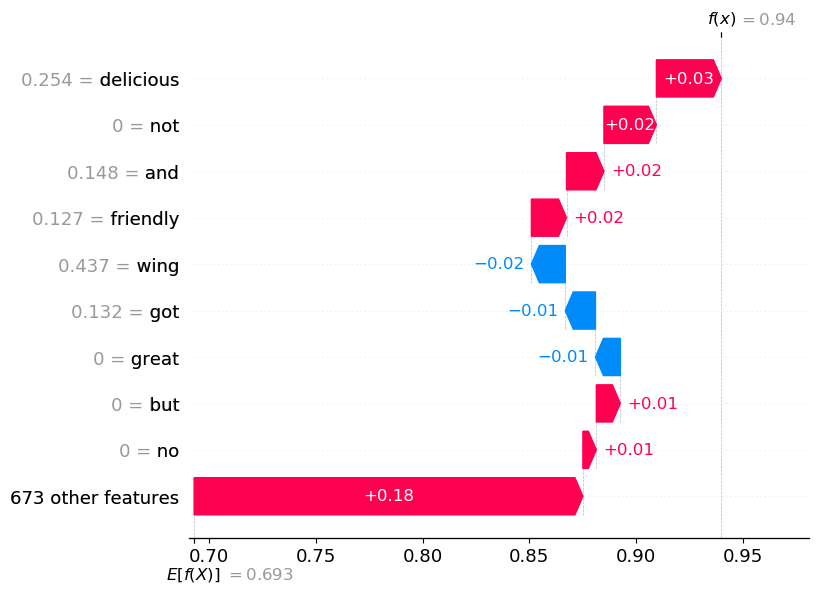

In [10]:
shap.initjs()
ind = 100

print(X_test.iloc[ind])

shap.plots.waterfall(shap_values[ind,:,1])

Wooow this graph looks like a bad review. First of all, the prediction is said to be $f(x) = 0.27$, this is BAD. Lets investigate the words: 
- **rude**: this word is indeed very negative. It has a TF-IDF of $0.243$ meaning that is important and it decreases the base value $-0.1$ which is huge for a SHAP value, understand that just with this word the value goes from $0.693$ to $0.593$. 
- **no**: no is more of a treaky word because you have to give it context in order to understand if it's good or bad, but the way it is written.. it seems that the algorithm knows it is considered bad here. It has a TF-IDF of $0.158$ which is quite high and decreases the base value $-0.04$. 
- **said**: said is just a word but look how the model knows that said and no together are a bad thing. It has a TF-IDF of $0.2$ and a SHAP value of $-0.07$ meaning that it decreases the base value. 

This is indeed a very bad review and the algorithm knows it. 

Hostess wa rude when I asked if there were any seat didn't tell me a wait or ask to reserve a seat just said "no"! Needless to say i didn't stick around.


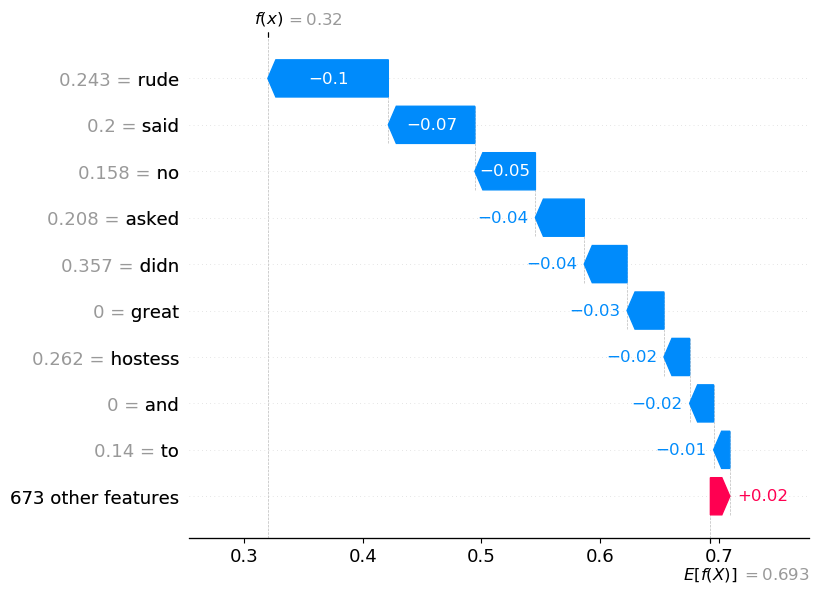

In [11]:
shap.initjs()
ind = 90

print(X_test.iloc[ind])

shap.plots.waterfall(shap_values[ind,:,1])

Now that we have seen local predictions, lets see how actual words affect the predictions. We will start with the word ``worst``. Before going into the graph, think about how the word ``worst`` should affect the reviews....

The X axis indicates the TF-IDF (importance) of the word and the Y axis indicates the SHAP value of the words ``worst`` found in the reviews. We can see that most of the are quite important having TF-IDF values of $0.2-0.4$ and the SHAP values are very low $-0.02$, $-0.06$, $-0.08$, $-0.1$. This means that using this word in a review will clearly decrease the base value and make the prediction lower. 

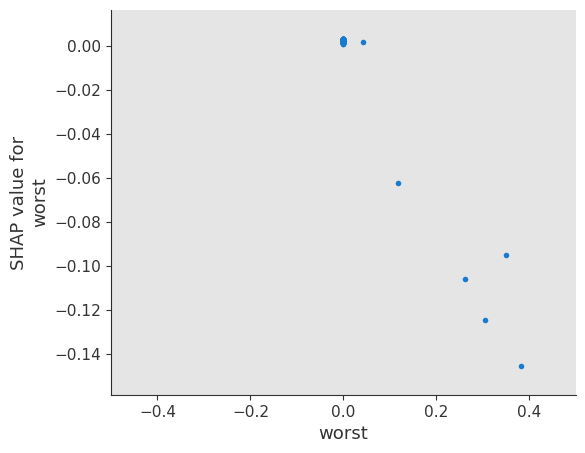

In [12]:
shap.plots.scatter(shap_values[:,feature_names.index("worst"),1])

Now lets take the word ``amazing``. Amazing seems important with TF-IDF of $0.2-0.4$ but... the SHAP values do not reach high values such as the ones from worst. This means that, putting a word with a very negative connotation will affect more that putting one good word. This made me think about how people should writte the restaurant reviews in order to make an impact.  

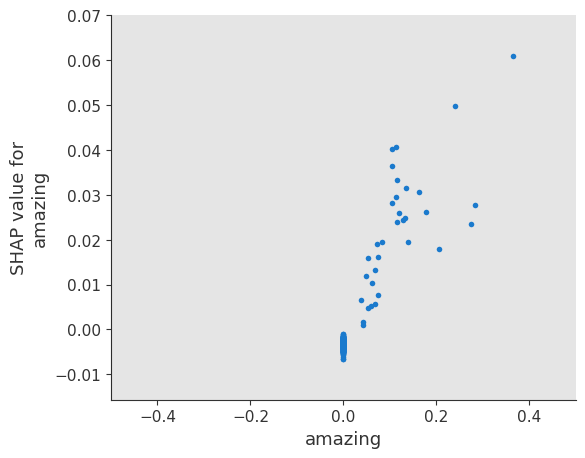

In [13]:
shap.plots.scatter(shap_values[:,feature_names.index("amazing"),1])

Best is also a good word. It appears that this word has also a TF-IDF  of $0.2-0.4$ but the SHAP values are not that high, they slightly reach $0.03$. 

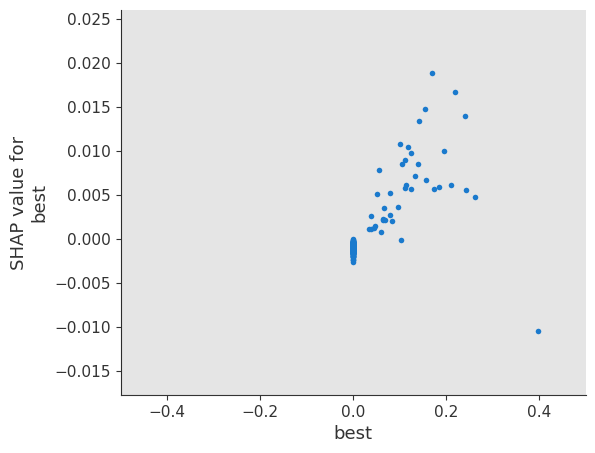

In [14]:
shap.plots.scatter(shap_values[:,feature_names.index("best"),1])

Now look at the word `not`! Not is a complicated word, because if we analyze it from a lexical perspective, it can be arranged with all kinds of words. It appears to have a negative connotation normally, SHAP values under 0, from $-0.025 \to -0.15$ which is huge compared to the good words, the thing is, it does not have a very high importance (TF-IDF) because it is also highly repeated. 

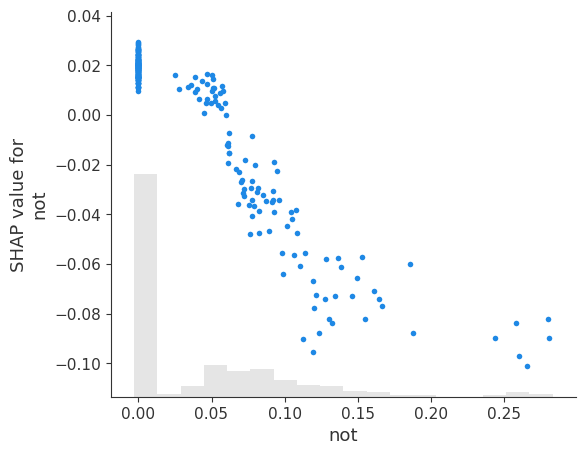

In [15]:
shap.plots.scatter(shap_values[:,feature_names.index("not"),1])

## In conclusion we can understand: 
1. Words have power, some more than others. Negative adjectives tend to have more power than positive ones in terms of reducing the SHAP value. Let's say that to eclipse a bad word you would have to use 2 very good ones.


2. If we want a review to affect a business either positively or negatively, we must construct our opinion in a clear and concise way, using many qualifying adjectives and if they can have a disproportionate connotation the better, both for positivity and negativity; for example: "terrible", "wonderful", "magnificent", "horrible", "disgusting", all are strong adjectives with a high capacity of expression.


3. It is bet now to use complex sentences such as "I did not like the food" it is better to write "The food was terrible", the same for any positive review, we must be clear and use the words directly. The stronger the adjective used the better. 

# 3. Graphos and other possible options
NetworkX is a Python library for creating and manipulating graphs and networks. You can use it to create graphs that represent relationships between different objects or entities, and then visualize those graphs using various layout algorithms. The image below shows an example of a graph made with networkx, that shows the professional theatre lighting designers in New York City. This can be done with almost anything and it is very interesting. 
![graph](../images/graph.png)

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
#vectorize the text. 

vectorizer = TfidfVectorizer()
reviews_vectors = vectorizer.fit_transform(df['text'])

The cosine similarity is a measure of similarity between two non-zero vectors of an inner product space that measures the cosine of the angle between them. In the context of restaurant reviews, calculating the cosine similarity between two reviews can give you a sense of how similar the reviews are in terms of the words they contain.

One possible use of calculating the cosine similarity between reviews is to identify pairs of reviews that are similar to each other. For example, if two reviews contain many of the same words and have a high cosine similarity, they may be expressing similar opinions about the restaurant. **This information could be useful for identifying patterns or trends in the reviews.**

Another possible use of cosine similarity is to create a graph of the reviews, with the cosine similarity values between each pair of reviews used as the weights of the edges in the graph. This can allow you to visualize the relationships between the reviews and see how they are connected to each other.

Overall, calculating the cosine similarity between reviews can be a useful way to understand the relationships between them and identify patterns or trends in the data.

In [17]:
from sklearn.metrics.pairwise import cosine_similarity
similarity_scores = cosine_similarity(reviews_vectors)

In [18]:
import networkx as nx
#making the graph

G = nx.Graph()
for i, review in enumerate(df['text']):
    G.add_node(i, review=review)

In [19]:
for i in range(len(df)):
    for j in range(i+1, len(df)):
        G.add_edge(i, j, weight=similarity_scores[i][j])

In [20]:
import networkx as nx
nx.write_graphml(G, "graph_1.graphml")

The graph we have in here is a graph that represents the relationships of the different reviews of the dataset. Each number corresponds to a review of a restaurant. For example: starting from the left centered part of the graph: 
- label 103: appears to be a good review, it talks about how good the food was. 
- label 190: this one is also a good review, it talks about the delicious food of the restaurant. 
- label 277: also a very good review. 

Lets move to the other part of the graph the right centered: 
- label 18: bad review
- label 278: bad review
- label 23: bad review

The graph groups the reviews by similar words and similar experiences. 

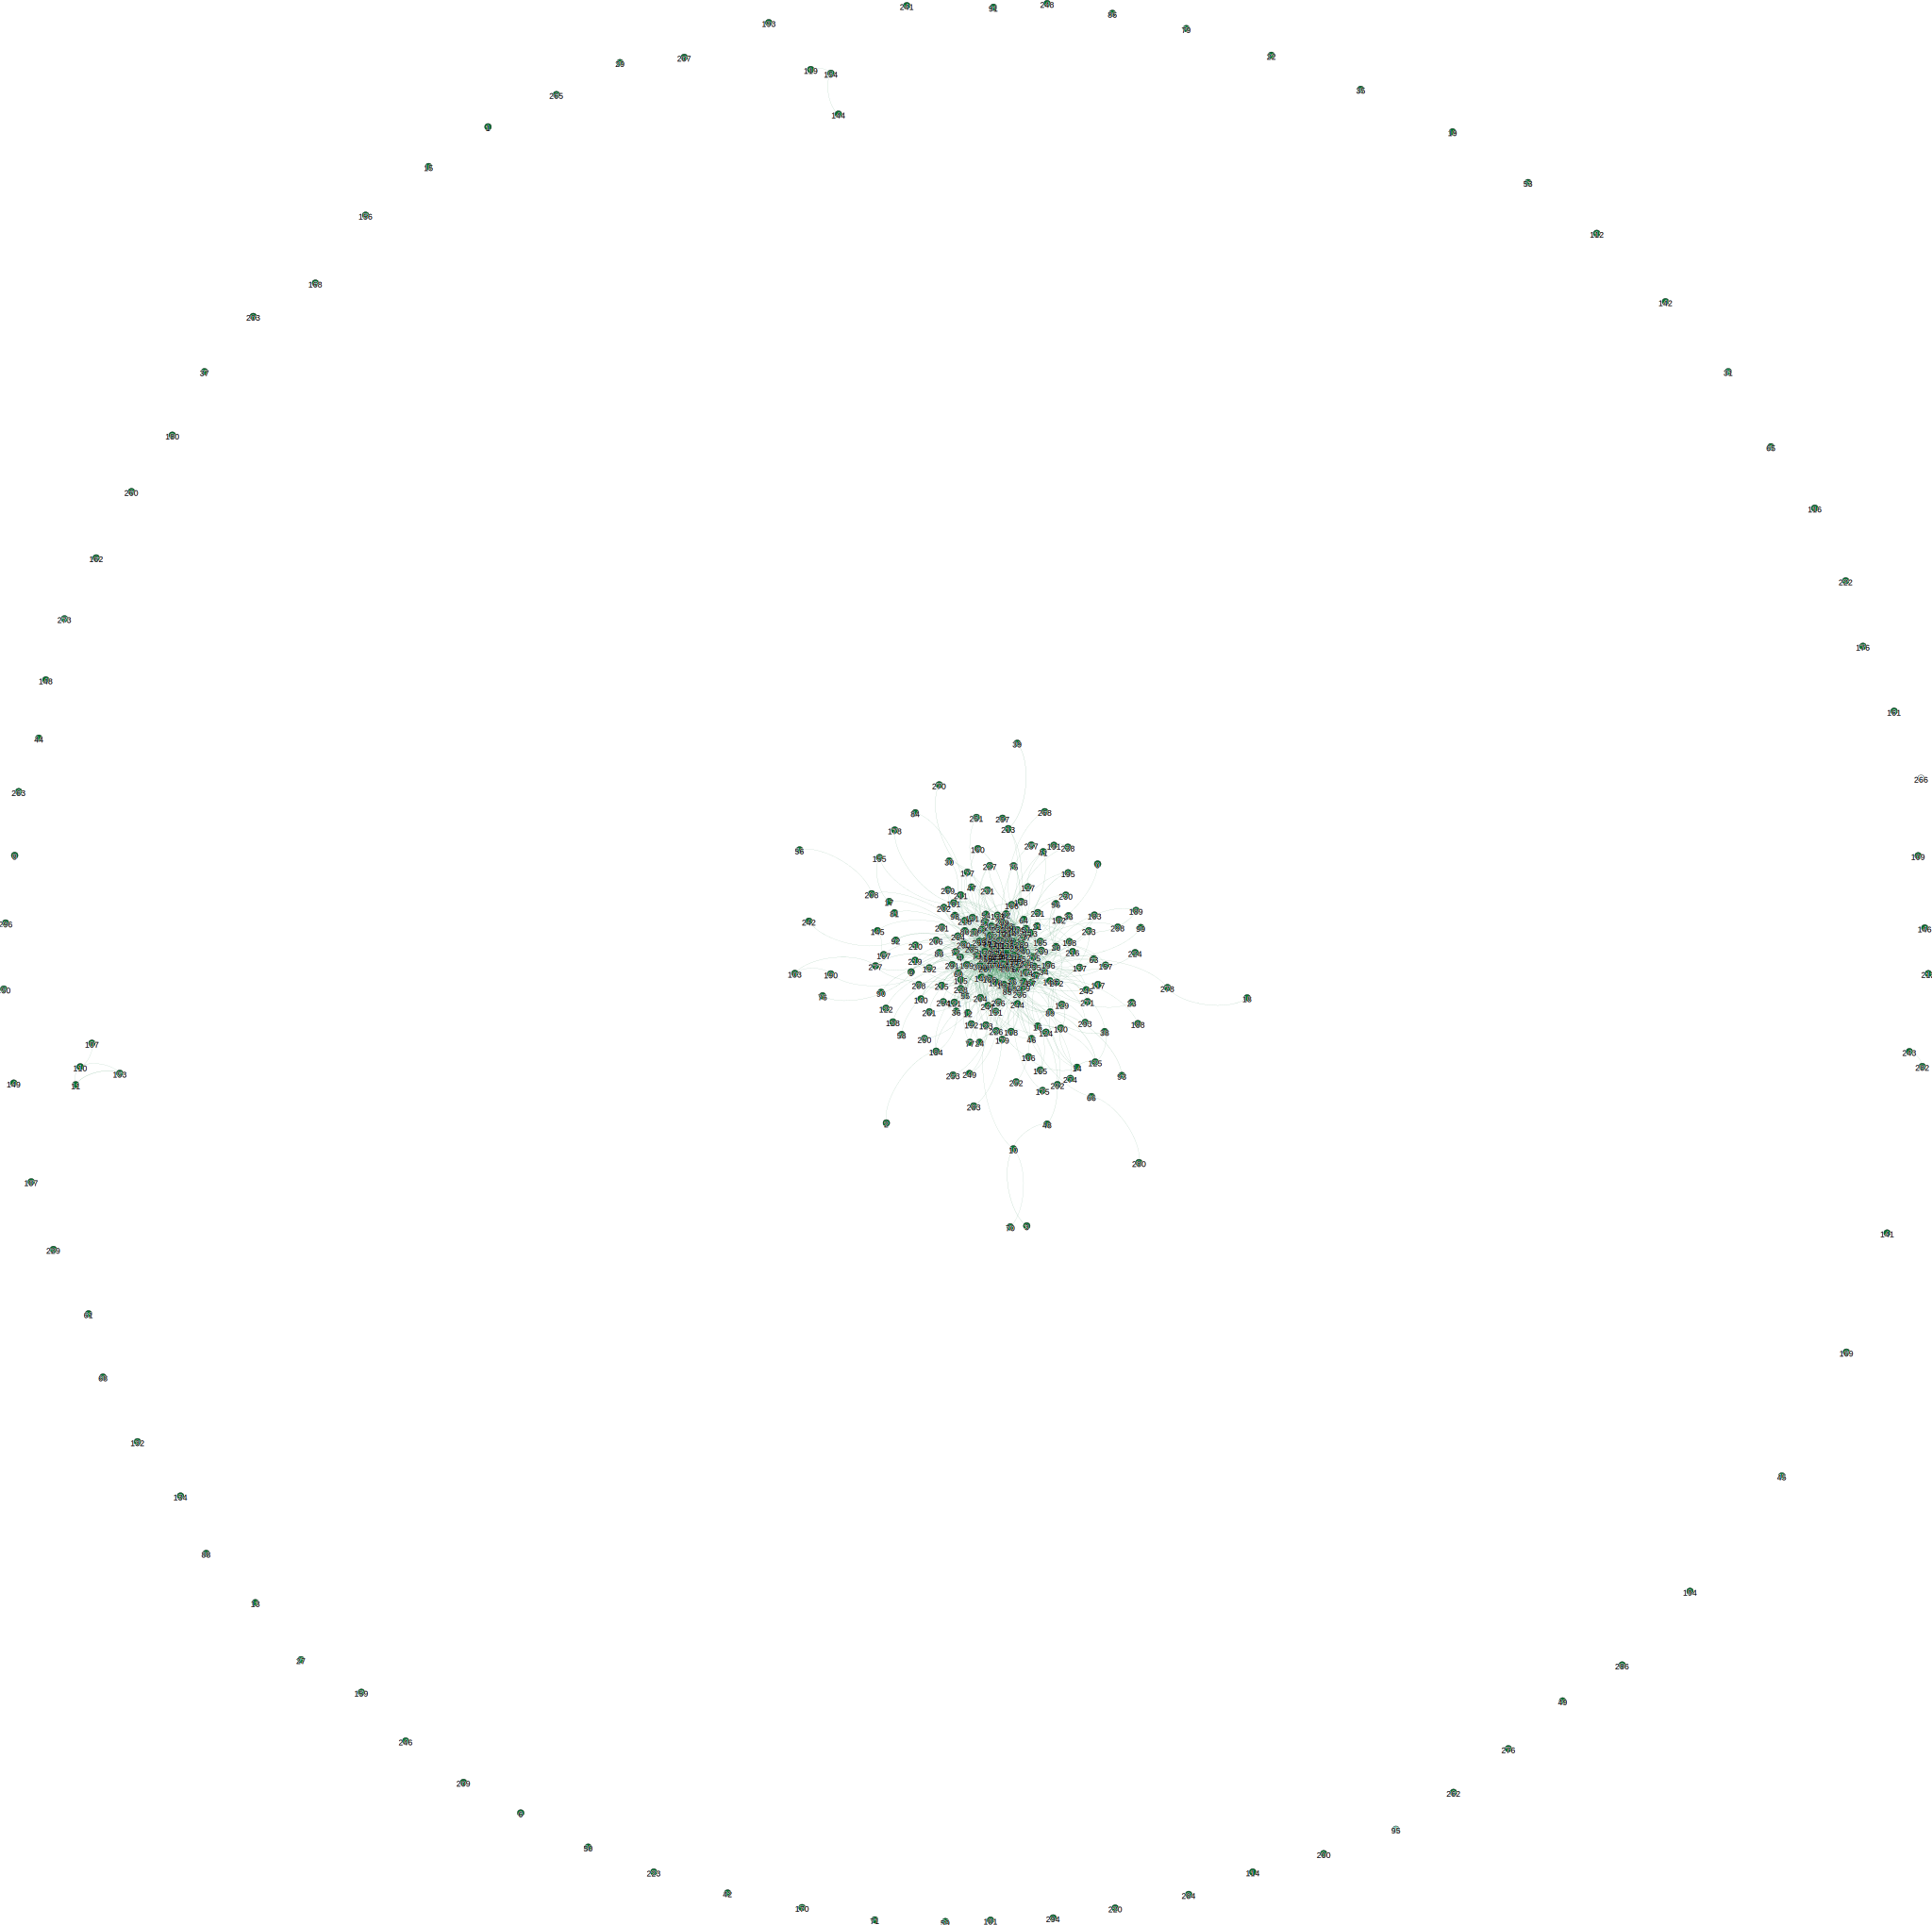

In [21]:
from IPython.display import SVG
SVG(filename='../images/reviews_refresh.svg')